<a href="https://colab.research.google.com/github/Ammar-Azman/behavior_prediction_jobads_text/blob/main/Behavior_Analysis_and_Prediction_based_on_Jobads_Dataset_Ammar_Azman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documentation

## Overview
- Author: Ammar Azman

## Objective
- Objective 1: To predict the behavior of user based on the text description and location for multimodal model.
- Objective 2: To create a recommender system based on the text desciption and job classification.

## Dataset
- 2 sources of dataset
    - ads-50k-events.csv
    - ads-50k.json

## Modeling Experimentation results
|Model idx|Model name|Features col|Target col|Epochs|Accuracy (%)|
|---|---|---|---|---|---|
|  0|Naive-Bayes|title,abstract,content|kind|-|56.39   |
|  1|Bi-LSTM|title,abstract,content   |kind   |10   |56.88   |
|1.1|Bi-LSTM (multimodal)|title,abstract,content,location|kind|10   |57.39|
|1.1|Bi-LSTM (multimodal)|title,abstract,content,location|kind|20   |57.81|
|2|Bi-LSTM|title,abstract,content   |classification|10|8.50   |

## Analysis

- Deep learning modelling sucessfully exceed the accuracy of base model.
- Theoritically, by increasing the epochs of training, the model accuracy will improve.
- However, there is a limitation in terms of computation power due to model is trained by using Google Colab free GPU (Tesla T4). Kernel has down for some reasons.
- Possible further experimentation:
    - Case 1:
        - [ ] Training for 100 epochs
        - [ ] Using pre-trained embedding (USE) and Huggingface transformer model.
        - [ ] Using different columns for multi-modal model.
        - [ ] Using useful callbacks such as RecudeLROnPlateau and EarlyStopping.
    - Case 2:
        - [ ] Building similarity score algorithm based on embedding vector.

# Google Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import re
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
!pip install tqdm

# Path

In [ ]:
from google.colab import userdata
path_string = userdata.get('PROJECT_PATH')

In [ ]:
from pathlib import Path

project_path = Path(path_string)
project_path.exists()

True

# Load event data

In [ ]:
ads_event_df = pd.read_csv(project_path/"ads-50k-events.csv")
ads_event_df.head(5)

,event_datetime,resume_id,job_id,event_platform,kind
0,2021-05-01T08:42:05,158655,38820886,IOS_APP,V
1,2021-05-01T08:42:05,158655,38901970,IOS_APP,V
2,2021-05-01T08:42:05,158655,38919645,IOS_APP,V
3,2021-05-01T08:42:05,158655,38928402,IOS_APP,V
4,2021-05-01T08:42:05,158655,38847632,IOS_APP,V


## df shape

In [ ]:
ads_event_df.shape

(4304688, 5)

In [ ]:
ads_event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4304688 entries, 0 to 4304687
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   event_datetime  object
 1   resume_id       int64 
 2   job_id          int64 
 3   event_platform  object
 4   kind            object
dtypes: int64(2), object(3)
memory usage: 164.2+ MB


In [ ]:
ads_event_df.describe()

,resume_id,job_id
count,4.304688e+06,4.304688e+06
mean,6.112633e+04,3.891131e+07
std,8.809239e+04,8.036513e+04
min,1.000000e+00,3.465109e+07
25%,5.260000e+03,3.887031e+07
50%,1.109200e+04,3.891773e+07
75%,7.450300e+04,3.896022e+07
max,4.393290e+05,3.908507e+07


## Check unique value

In [ ]:
df_cols = ads_event_df.columns

for col in df_cols:
    unique_val = ads_event_df[col].unique()
    print(f"Col: {col}\nUnique_val: {unique_val}\nlen: {len(unique_val)}\n\n")

Col: event_datetime
Unique_val: ['2021-05-01T08:42:05' '2021-05-01T04:40:12' '2021-05-01T01:33:43' ...
 '2021-05-01T22:12:50' '2021-05-01T22:35:45' '2021-05-01T22:34:25']
len: 55478


Col: resume_id
Unique_val: [158655 127523 270589 ...  99807  11124  97605]
len: 29578


Col: job_id
Unique_val: [38820886 38901970 38919645 ... 38921473 38953734 38953619]
len: 50000


Col: event_platform
Unique_val: ['IOS_APP' 'ANDROID_APP' 'WEB']
len: 3


Col: kind
Unique_val: ['V' 'A']
len: 2




## Check NaN

In [ ]:
for col in df_cols:
    nan_val = ads_event_df[col].isna().sum()
    print(f"Col: {col}\nnan_val: {nan_val}\n\n")

Col: event_datetime
nan_val: 0


Col: resume_id
nan_val: 0


Col: job_id
nan_val: 0


Col: event_platform
nan_val: 0


Col: kind
nan_val: 0




## Check value counts

In [ ]:
for col in df_cols:
    value_count = ads_event_df[col].value_counts()
    print(f"Col: {col}\nvalue_count:\n {value_count}\n")

Col: event_datetime
value_count:
 2021-05-01T02:25:28    942
2021-05-01T02:29:33    879
2021-05-01T01:29:19    867
2021-05-01T21:24:03    855
2021-05-01T03:28:36    840
                      ... 
2021-05-01T15:17:38      3
2021-05-01T20:33:21      3
2021-05-01T01:57:15      3
2021-05-01T05:24:40      3
2021-05-01T22:34:25      3
Name: event_datetime, Length: 55478, dtype: int64

Col: resume_id
value_count:
 245       10077
3272       7518
6517       7215
4456       5826
5082       5232
          ...  
97954         3
328639        3
70934         3
159248        3
42443         3
Name: resume_id, Length: 29578, dtype: int64

Col: job_id
value_count:
 38843647    1167
38862323    1167
38842752    1167
38879327    1167
38837807    1167
            ... 
38972551       3
38984963       3
38928700       3
38987513       3
38953619       3
Name: job_id, Length: 50000, dtype: int64

Col: event_platform
value_count:
 WEB            1520004
IOS_APP        1423281
ANDROID_APP    1361403
Name: ev

## Check duplicate

In [ ]:
test_df = ads_event_df[(ads_event_df["resume_id"] == 158655) &\
                       (ads_event_df["job_id"] == 38820886)]
test_df

,event_datetime,resume_id,job_id,event_platform,kind
0,2021-05-01T08:42:05,158655,38820886,IOS_APP,V
36,2021-05-01T08:42:05,158655,38820886,IOS_APP,V
72,2021-05-01T08:42:05,158655,38820886,IOS_APP,V


In [ ]:
df_duplicate = ads_event_df[ads_event_df.job_id.duplicated()]
df_duplicate.shape, ads_event_df.shape

((4254688, 5), (4304688, 5))

In [ ]:
4304688 - 4254688

50000

## drop duplicate

In [ ]:
event_df = ads_event_df.copy()

In [ ]:
event_df = event_df.drop_duplicates()
event_df.shape

(1434896, 5)

## cast datetime

In [ ]:
event_df["event_datetime"] = pd.to_datetime(event_df["event_datetime"])
event_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434896 entries, 0 to 4304679
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   event_datetime  1434896 non-null  datetime64[ns]
 1   resume_id       1434896 non-null  int64         
 2   job_id          1434896 non-null  int64         
 3   event_platform  1434896 non-null  object        
 4   kind            1434896 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 65.7+ MB


# Load jobads

In [ ]:
job_ads_df = pd.read_json(project_path/"ads-50k.json", chunksize=100, lines=True)
job_ads_df

In [ ]:
from tqdm import tqdm

In [ ]:
df_chunks = list()
for chunk in tqdm(job_ads_df):
    df_chunks.append(chunk)
print("Saving chunks completed.")

500it [00:04, 104.62it/s]

Saving chunks completed.


In [ ]:
len(df_chunks)

500

In [ ]:
df_chunks[0].iloc[1]

id                                                   38934839
title                          Computers Salesperson - Coburg
abstract    Passionate about exceptional customer service?...
content     <HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...
metadata    {'additionalSalaryText': 'Attractive Commissio...
Name: 1, dtype: object

## clean metadata value fx

In [ ]:
def clean_metadata(text)->str:
    clean_text = text[text.rfind(":")+1:].replace("'", "").replace("}", "")
    return clean_text

clean_metadata("Attractive Commission - Uncapped Earning Potential")

'Attractive Commission - Uncapped Earning Potential'

## clean content text fx

In [ ]:
def clean_content(text:str)->str:
    # text = text.replace("<p>", "").replace("</p>", " ")
    # text = text.replace("<li>", "").replace("</li>", " ")
    # text = text.replace("<ul>", "").replace("</ul>", " ")
    # text = text.replace("<strong>", "").replace("</strong>", " ")
    # text = text.replace("<HTML>", "").replace("</HTML>", "")
    # text = text.replace("<div>", " ").replace("</div>", " ")
    # text = text.replace("&middot;", " ").replace("&nbsp;"," ")
    # text = text.replace('<p style="text-align: justify;">', " ")
    # text = text.replace('<em>', " ").replace("</em>", " ")
    pattern = re.compile('<.*?>')
    text = re.sub(pattern, ' ', text)
    return text

In [ ]:
row_num = 1
id = df_chunks[0].iloc[row_num].id
title = df_chunks[0].iloc[row_num].title
abstract = df_chunks[0].iloc[row_num].abstract
content = df_chunks[0].iloc[row_num].content
metadata = df_chunks[0].iloc[row_num].metadata
print(f"id: {id}\n")
print(f"title: {title}\n")
print(f"abstract: {abstract}\n")
print(f"content: {clean_content(content)}\n")
print("Metadata:\n")
print("additionalSalaryText: ", clean_metadata(metadata["additionalSalaryText"])) # text
print("additionalSalaryText-raw: ", metadata["additionalSalaryText"]) # text

print("classification: ", metadata["classification"]["name"])
print("subClassification: ", metadata["subClassification"]["name"])
print("location: ", metadata["location"]["name"])
print("suburb: ", metadata["suburb"]["name"])
print("workType: ", metadata["workType"]["name"])

id: 38934839

title: Computers Salesperson - Coburg

abstract: Passionate about exceptional customer service? 
Excited about selling? 
Discover a great place to work at Harvey Norman and share our success

content:   &middot;&nbsp;&nbsp;Casual hours as required (transition to Part-time or Full-time available) &middot;&nbsp; Attractive commission based structures &middot;&nbsp; Paths for career progression with a trusted national brand  Discover a great place to work at Harvey Norman with over 180 stores nationwide. Harvey Norman is an Australian retail icon with a strong market reputation and performance in the retail categories of furniture and bedding, flooring, bathrooms and kitchen renovations, electrical goods, small appliances, technology and entertainment. 
 We are seeking an enthusiastic customer service focused Salesperson to join the Coburg Store. 
 Our Salespeople have an understanding of life at home solutions and a desire to find the best outcome for our customers. 
  To b

## processing metadata fx


In [ ]:
# test development
def split_metadata(df):
    metadata = df.iloc[row_num].metadata

    # special case
    if "additionalSalaryText" in metadata.keys():
        salary = clean_metadata(metadata["additionalSalaryText"])
    else:
        salary = np.NAN

    if "suburb" in metadata.keys():
        suburb = metadata["suburb"]["name"]
    else:
        suburb = np.NAN

    classification = metadata["classification"]["name"]
    sub_class = metadata["subClassification"]["name"]
    location = metadata["location"]["name"]
    work_type = metadata["workType"]["name"]

    return salary, classification, sub_class, location, suburb, work_type

## df full cleaning fx

In [ ]:


def df_clean_content(df):
    clean_content_text = df["content"].apply(lambda x: clean_content(x))
    return clean_content_text

def drop_col(df, cols:list):
    df_new = df.drop(cols, axis=1)
    return df_new

def df_full_clean(df):
    salary, classification, sub_class, location, suburb, work_type = split_metadata(df)
    df["content"] = df_clean_content(df)
    # special case
    df["additionalSalaryText"] = salary
    df["suburb"] = suburb

    df["classification"] = classification
    df["subClassification"] = sub_class
    df["location"] = location
    df["workType"] = work_type

    df = drop_col(df, ["metadata"])
    return df


# df_clean_content(test_df)


In [ ]:
# debugging
df_chunks[1].iloc[3]

id                                                   38988412
title                                         Project Manager
abstract    Join a multinational company looking to furthe...
content     <HTML><p style="text-align: justify;"><strong>...
metadata    {'standout': {'bullet1': 'Deputy Project Manag...
Name: 103, dtype: object

In [ ]:
test_df = df_chunks[1]
df_full_clean(test_df)

,id,title,abstract,content,additionalSalaryText,suburb,classification,subClassification,location,workType
100,38836542,Senior Technical Business Analyst,2 x Senior Technical BA roles working in a fas...,My client is a global innovative technology c...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
101,38942692,Senior OT - Case Manager CCT/FEP,A fantastic opportunity for an experienced Cas...,12 months fixed term maternity leave bac...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
102,38931390,Senior Facilities Manager,Utilise your previous experience to manage two...,&nbsp; EARN a Negotiable Salary Bas...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
103,38988412,Project Manager,Join a multinational company looking to furthe...,Our client is a leading international engin...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
104,38912011,Part time Barista in Maroubra,A cafe/bar in Maroubra is seeking a part time ...,A cafe/bar in Maroubra is seeking a p...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
...,...,...,...,...,...,...,...,...,...,...
195,38946665,Trades Assistants - Electrical - Throughout Du...,"To be successful for this role, you must have ...","To be successful for this role, you must ha...",NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
196,38916572,Bridge Drafter,Bridge drafter with strong AutoCAD software sk...,Bridge drafter with strong AutoCAD software ...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
197,38830145,Systems Engineer (splunk),As the Splunk Build Engineer you will work to ...,\n World-leading application of technology. ...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp
198,38889814,Produce Manager PNS Clendon,PAK'nSAVE Clendon are looking for a Produce Ma...,CLENDON &nbsp; PRODUCE MANAGER &nbsp;...,NaN,Fitzroy,Healthcare & Medical,"Physiotherapy, OT & Rehabilitation",Melbourne,Contract/Temp


## merging full cleaning df

In [ ]:
len(df_chunks)

500

In [ ]:
clean_df_chunks = list()
for idx, chunk in enumerate(df_chunks):
    try:
        clean_chunk = df_full_clean(chunk)
        clean_df_chunks.append(clean_chunk)
    except Exception as err:
        print(idx, err)
        pass

In [ ]:
jobads_final_df = pd.concat(clean_df_chunks)
jobads_final_df.shape

(50000, 10)

In [ ]:
jobads_final_df.head(5)

,id,title,abstract,content,additionalSalaryText,suburb,classification,subClassification,location,workType
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,Are you looking to join a thriving business ...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,&middot;&nbsp;&nbsp;Casual hours as required...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation
2,38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,Readify helps organizations innovate with te...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation
3,38833950,Senior Commercial Property Manager | Leading T...,~ Rare opportunity for a Senior PM to step int...,WayPoint Recruitment&nbsp; have partnered u...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation
4,38856271,Technology Manager | Travel Industry,Rare opportunity for an experienced Technology...,This is a key role within a market leading Tr...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation


# **Data Insight**

- `event_df` has 1434896 rows, while `jobads_final_df` has 50000 rows.
- Primary key and foreign key from both dataset repsectively, - ads_event_df.job_id == jobads_final_df.id

# Event data analysis

- kind
    - "V" - view
    - "A" - application

In [ ]:
event_df = event_df.copy()

In [ ]:
event_df.head(3)

,event_datetime,resume_id,job_id,event_platform,kind
0,2021-05-01 08:42:05,158655,38820886,IOS_APP,V
1,2021-05-01 08:42:05,158655,38901970,IOS_APP,V
2,2021-05-01 08:42:05,158655,38919645,IOS_APP,V


## EDA

(<Axes: >,
 WEB            506668
 IOS_APP        474427
 ANDROID_APP    453801
 Name: event_platform, dtype: int64)

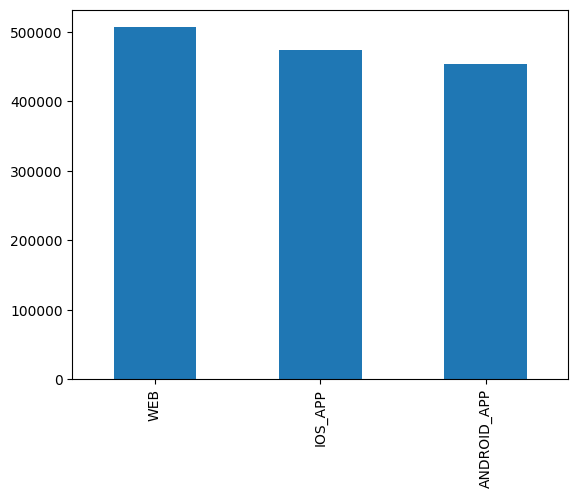

In [ ]:
event_df["event_platform"].value_counts().plot(kind="bar"),event_df["event_platform"].value_counts()

(<Axes: >,
 V    1314401
 A     120495
 Name: kind, dtype: int64)

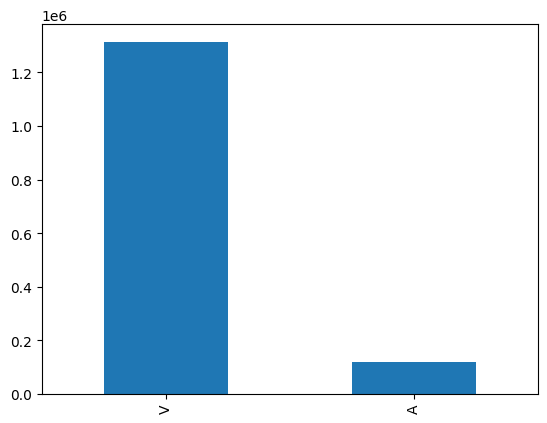

In [ ]:
event_df["kind"].value_counts().plot(kind="bar"), event_df["kind"].value_counts()

## Insights

**Platform Visitors**
- Website has the highest visitors compare to Mobile (Android and IOS), followed with IOS and the last Android
- Suggestion: Improve features on mobile app to increase more visitors.

**Kind (behavior)**
- The ratio between View and Application is significantly high.


## Time Series

In [ ]:
view_df = event_df[event_df["kind"] == "V"].set_index("event_datetime")
appl_df = event_df[event_df["kind"] == "A"].set_index("event_datetime")

In [ ]:
view_df = view_df.groupby("event_datetime")["kind"].sum().reset_index()
view_df["count_kind"] = view_df["kind"].apply(lambda x: len(x))
view_df = view_df[["event_datetime", "count_kind"]]# .set_index("event_datetime")


appl_df = appl_df.groupby("event_datetime")["kind"].sum().reset_index()
appl_df["count_kind"] = appl_df["kind"].apply(lambda x: len(x))
appl_df = appl_df[["event_datetime", "count_kind"]]# .set_index("event_datetime")

In [ ]:
view_df_hour = view_df.groupby([view_df['event_datetime'].dt.hour]).count_kind.sum()
appl_df_hour = appl_df.groupby([appl_df['event_datetime'].dt.hour]).count_kind.sum()

# view_df_min = view_df.groupby([view_df['event_datetime'].dt.minute]).count_kind.sum()

([<matplotlib.axis.XTick at 0x790164880040>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

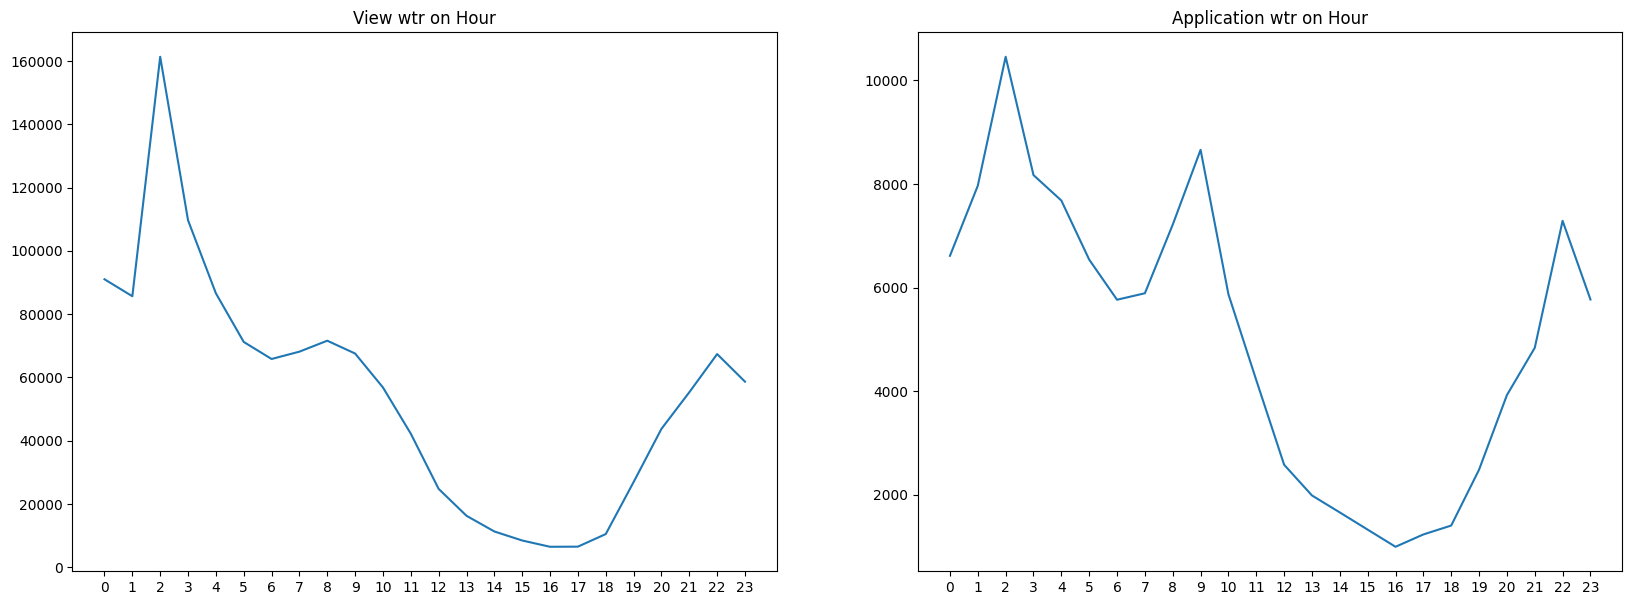

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title("View wtr on Hour")
plt.plot(view_df_hour)
plt.xticks(view_df_hour.index)

plt.subplot(1,2,2)
plt.title("Application wtr on Hour")
plt.plot(appl_df_hour)
plt.xticks(appl_df_hour.index)

### **Insight**

**View**
- In the morning, 2 am showed the highest view on all platform.
- At night, 10 pm showed the peak of the view on all platform.

**Application**
- There are 2 peaks for application on the morning - 2 am and 9 am.
- While at night, it higher at 10 pm.

# Jobads data analysis

In [ ]:
jobads_final_df.head(2)

,id,title,abstract,content,additionalSalaryText,suburb,classification,subClassification,location,workType
0,38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,Are you looking to join a thriving business ...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation
1,38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,&middot;&nbsp;&nbsp;Casual hours as required...,Attractive Commission - Uncapped Earning Poten...,Coburg,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation


## EDA

<Axes: >

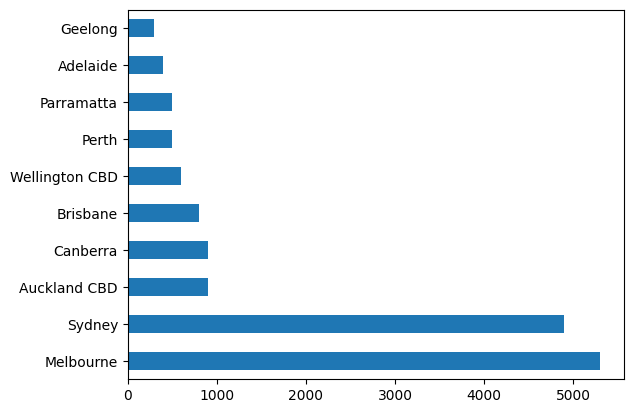

In [ ]:
jobads_final_df["suburb"].value_counts()[:10].plot(kind="barh")

<Axes: >

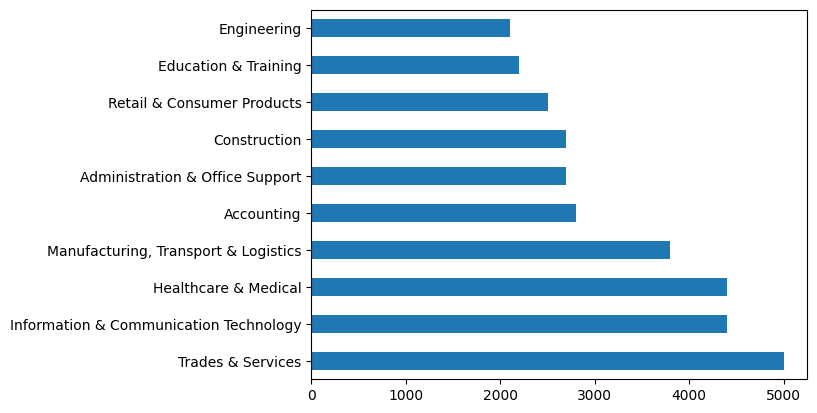

In [ ]:
jobads_final_df["classification"].value_counts()[:10].plot(kind="barh")

<Axes: >

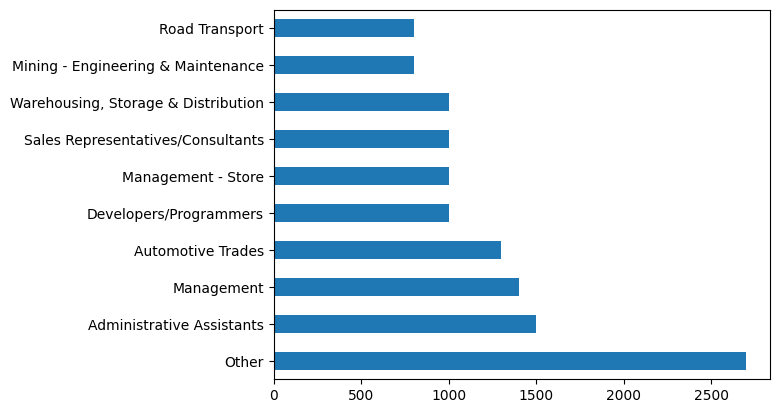

In [ ]:
jobads_final_df["subClassification"].value_counts()[:10].plot(kind="barh")

<Axes: >

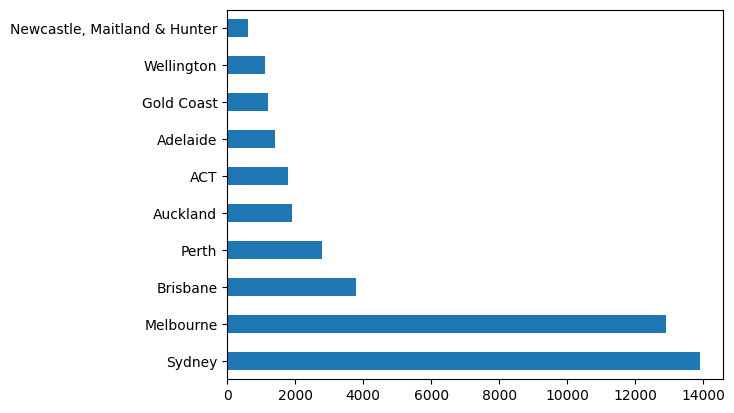

In [ ]:
jobads_final_df["location"].value_counts()[:10].plot(kind="barh")

<Axes: >

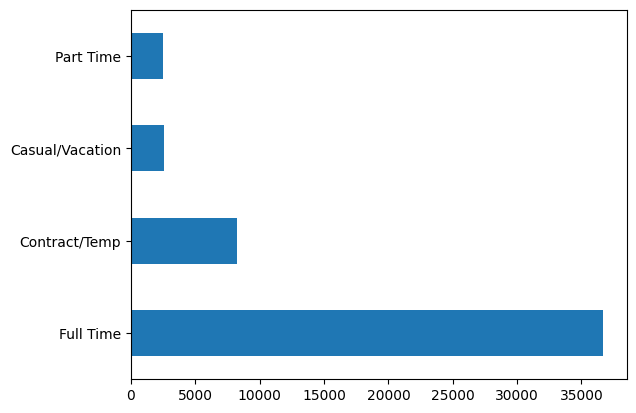

In [ ]:
jobads_final_df["workType"].value_counts()[:10].plot(kind="barh")

<Axes: >

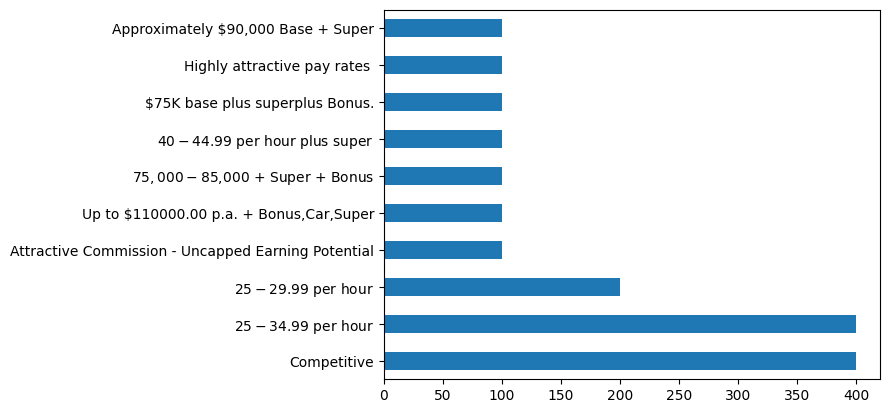

In [ ]:
jobads_final_df["additionalSalaryText"].value_counts()[:10].plot(kind="barh")

### Insight

- Most of JobAds is located in Australia, specifically in Adelaide, Sydney, followed by Melbourne.

- Infomation and Communication technology and Trade & Service has the highest categories of JobAds.

- Fulltime working type has the highest amount of JobAds compared to contract, vacation and part time.

# Full Dataset Analysis

## Combine both dataset (full_dataset)

In [ ]:
event_df.info(), jobads_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434896 entries, 0 to 4304679
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   event_datetime  1434896 non-null  datetime64[ns]
 1   resume_id       1434896 non-null  int64         
 2   job_id          1434896 non-null  int64         
 3   event_platform  1434896 non-null  object        
 4   kind            1434896 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 65.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    50000 non-null  int64 
 1   title                 50000 non-null  object
 2   abstract              50000 non-null  object
 3   content               50000 non-null  object
 4   additionalSalaryText  1670

(None, None)

In [ ]:
event_df.shape, jobads_final_df.shape

((1434896, 5), (50000, 10))

In [ ]:
event_df.columns, jobads_final_df.columns

(Index(['event_datetime', 'resume_id', 'job_id', 'event_platform', 'kind'], dtype='object'),
 Index(['id', 'title', 'abstract', 'content', 'additionalSalaryText', 'suburb',
        'classification', 'subClassification', 'location', 'workType'],
       dtype='object'))

In [ ]:
# merge event_df and jobads_final_df to become full dataset


full_dataset = pd.merge(event_df, jobads_final_df, how="left",
                        left_on="job_id", right_on="id").set_index("id")
full_dataset.columns

Index(['event_datetime', 'resume_id', 'job_id', 'event_platform', 'kind',
       'title', 'abstract', 'content', 'additionalSalaryText', 'suburb',
       'classification', 'subClassification', 'location', 'workType'],
      dtype='object')

In [ ]:
full_dataset.head(2)

,event_datetime,resume_id,job_id,event_platform,kind,title,abstract,content,additionalSalaryText,suburb,classification,subClassification,location,workType
id,,,,,,,,,,,,,,
38820886,2021-05-01 08:42:05,158655,38820886,IOS_APP,V,Pharmacist - Part Time - Melton,Expand your career with a leading pharmacy ret...,A career with endless opportunities is clo...,NaN,Auckland CBD,Sales,Account & Relationship Management,Auckland,Full Time
38901970,2021-05-01 08:42:05,158655,38901970,IOS_APP,V,Assistant Director - EL1,"Experienced EL 1 Assistant Director, Strategy ...",face2face reference number: 10600 3 M...,NaN,Melbourne,Trades & Services,Technicians,Melbourne,Contract/Temp


In [ ]:
full_dataset.job_id.isna().sum()

0

## Higest and lowest Interaction based on Features
- Salary
- Location

In [ ]:
def interaction_features(kind_val:str, feature:str, get_sort=False):
    df = full_dataset.copy()
    interaction_df = df[df["kind"] == kind_val].\
                      groupby(feature)\
                        ["kind"].sum().reset_index()
    interaction_df[f"count_{kind_val}"] = interaction_df["kind"].apply(lambda x: len(x))
    interaction_df = interaction_df.drop(["kind"], axis=1).sort_values(f"count_{kind_val}", ascending=get_sort)

    return interaction_df

## Pivot analysis

In [ ]:
df_t  = full_dataset.copy()

TO_OBSERVE =
pivot = pd.pivot_table(df_t,
                index=TO_OBSERVE,
                columns="kind",
                aggfunc=len,)[["abstract"]]
display(pivot)
pivot.plot(kind="barh")

abstract        
kind                  A       V
event_platform                 
ANDROID_APP       25235  428566
IOS_APP           26760  447667
WEB               68500  438168

<Axes: ylabel='event_platform'>

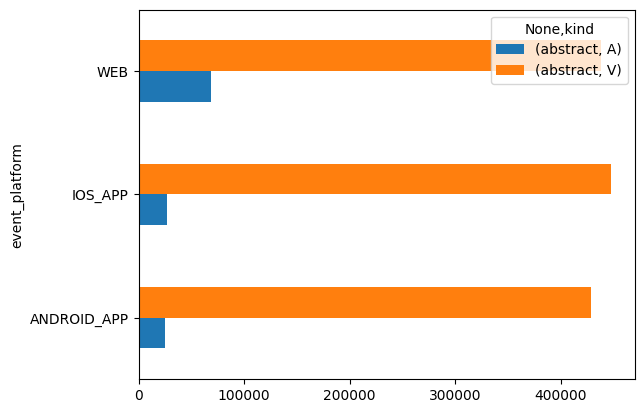

In [ ]:
display(interaction_features("V", "additionalSalaryText").head(5)), \
display(interaction_features("A", "additionalSalaryText").head(5))


,additionalSalaryText,count_V
21,$25 - $34.99 per hour,11717
119,Competitive,9444
20,$25 - $29.99 per hour,4808
113,Base + Super,3848
147,Salary Packages OR Commission Only,3757


,additionalSalaryText,count_A
21,$25 - $34.99 per hour,1206
119,Competitive,859
20,$25 - $29.99 per hour,382
137,Highly attractive pay rates,369
32,$40 - $44.99 per hour plus super,352


(None, None)

## Highest and Lowest Interaction (V and A) Work Type

In [ ]:
display(interaction_features("V", "workType").head(5)), \
display(interaction_features("A", "workType").head(5))

,workType,count_V
2,Full Time,963908
1,Contract/Temp,219134
0,Casual/Vacation,66525
3,Part Time,64834


,workType,count_A
2,Full Time,88873
1,Contract/Temp,19698
3,Part Time,6087
0,Casual/Vacation,5837


(None, None)

## Highest Lowest Interaction (V and A) on Location


In [ ]:
display(interaction_features("V", "location").head(5)), \
display(interaction_features("A", "location").head(5))

,location,count_V
39,Sydney,365183
25,Melbourne,335776
10,Brisbane,102345
30,Perth,73212
0,ACT,50496


,location,count_A
39,Sydney,33895
25,Melbourne,30224
10,Brisbane,9550
30,Perth,6652
5,Auckland,4471


(None, None)

# Model 0 (Base Model: Behavior Classifier)

## dataset and features

In [ ]:
full_dataset.head(2)

,event_datetime,resume_id,job_id,event_platform,kind,title,abstract,content,additionalSalaryText,suburb,classification,subClassification,location,workType
id,,,,,,,,,,,,,,
38820886,2021-05-01 08:42:05,158655,38820886,IOS_APP,V,Pharmacist - Part Time - Melton,Expand your career with a leading pharmacy ret...,A career with endless opportunities is clo...,NaN,Auckland CBD,Sales,Account & Relationship Management,Auckland,Full Time
38901970,2021-05-01 08:42:05,158655,38901970,IOS_APP,V,Assistant Director - EL1,"Experienced EL 1 Assistant Director, Strategy ...",face2face reference number: 10600 3 M...,NaN,Melbourne,Trades & Services,Technicians,Melbourne,Contract/Temp


In [ ]:
full_dataset["kind"].value_counts()

V    1314401
A     120495
Name: kind, dtype: int64

In [ ]:
BALANCE_SLICE = 12000

bs_dataset = full_dataset[["title","abstract","content","kind"]]# .iloc[:1000]
bs_V = bs_dataset[bs_dataset["kind"]=="V"].iloc[:BALANCE_SLICE]
bs_A = bs_dataset[bs_dataset["kind"]=="A"].iloc[:BALANCE_SLICE]

bs_dataset = pd.concat([bs_V, bs_A])

bs_dataset["full_text"] = bs_dataset["title"] + bs_dataset["abstract"] + bs_dataset["content"]
X_bs = bs_dataset["full_text"].to_numpy()
y_bs = bs_dataset["kind"].to_numpy()

## train test split

In [ ]:
X_trainbs, X_testbs, y_trainbs, y_testbs = train_test_split(
    X_bs,
    y_bs,
    test_size=.2,
    random_state=42
)

In [ ]:
X_trainbs.shape, y_trainbs.shape

((19200,), (19200,))

## fit

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multinom", MultinomialNB())
])

In [ ]:
model_0.fit(X_trainbs, y_trainbs)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('multinom', MultinomialNB())])

## evaluate

In [ ]:
model_0_score = model_0.score(X_testbs, y_testbs)
print(model_0_score)

0.5639583333333333


## test

In [ ]:
model_0_preds = model_0.predict(X_testbs)
model_0_preds[:10], y_testbs[:10]

(array(['V', 'A', 'V', 'A', 'A', 'V', 'A', 'A', 'V', 'V'], dtype='<U1'),
 array(['V', 'A', 'A', 'A', 'A', 'V', 'V', 'V', 'A', 'A'], dtype=object))

## Insight

- Baseline accuracy: 97%

## performance metrics

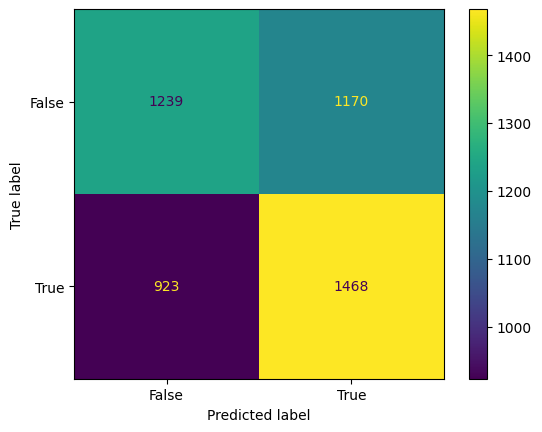

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cm = confusion_matrix(y_testbs, model_0_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

**Insight**

- Rsults showed high false positive and false negative within the base-model.

## pickle

In [ ]:
from joblib import dump, load
dump(model_0, project_path/'model_0.joblib')

## load

In [ ]:
model_0 = load(project_path/'model_0.joblib')
model_0.predict(X_testbs)

array(['V', 'A', 'V', ..., 'V', 'A', 'A'], dtype='<U1')

# Model 1 (Behavior Classifier with Deep Learning)
- Check keywords
- Has highest interaction


In [ ]:
full_dataset.columns

Index(['event_datetime', 'resume_id', 'job_id', 'event_platform', 'kind',
       'title', 'abstract', 'content', 'additionalSalaryText', 'suburb',
       'classification', 'subClassification', 'location', 'workType'],
      dtype='object')

In [ ]:
def combine_all_text(row_df):
    full_text = row_df["title"] + " " + row_df["abstract"] + " " + row_df["content"]
    return full_text

In [ ]:
text_df = full_dataset[["title", "abstract", "content", "kind"]]
text_df["full_text"] = text_df["title"] + text_df["abstract"] + text_df["content"]
text_df

<ipython-input-77-b8b512c5ce63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["full_text"] = text_df["title"] + text_df["abstract"] + text_df["content"]


,title,abstract,content,kind,full_text
id,,,,,
38820886,Pharmacist - Part Time - Melton,Expand your career with a leading pharmacy ret...,A career with endless opportunities is clo...,V,Pharmacist - Part Time - MeltonExpand your car...
38901970,Assistant Director - EL1,"Experienced EL 1 Assistant Director, Strategy ...",face2face reference number: 10600 3 M...,V,Assistant Director - EL1Experienced EL 1 Assis...
38919645,Property Manager - Luxury Portfolio,Higher Solution Specialists are currently seek...,Higher Solution Specialists is&nbsp;a privat...,V,Property Manager - Luxury PortfolioHigher Solu...
38928402,Looking for MC Drivers,MC Driver - there's more to them than meets th...,Are you ready to transform and roll out? W...,V,Looking for MC DriversMC Driver - there's more...
38847632,Executive Officer (ALTG & TACT) - Lung Foundat...,"Pivotal research program position, responsible...",About the Opportunity Lung Foundation Au...,V,Executive Officer (ALTG & TACT) - Lung Foundat...
...,...,...,...,...,...
38863789,Claims Consultant - Sutherland Location,SME Claims Portfolio Management - Great Career...,Enjoy working in a vibrant and supportive te...,V,Claims Consultant - Sutherland LocationSME Cla...
38977257,ESL Teachers: International Public Speaking St...,Hiring teachers in Sydney & Melbourne. Fun cas...,ABOUT GATEWAY LEARNING&nbsp;&nbsp; Gatew...,V,ESL Teachers: International Public Speaking St...
38943585,Travel Experts - Warringah,Want to combine your passion for travel with y...,Want to combine your passion for travel and ...,V,Travel Experts - WarringahWant to combine your...


In [ ]:
text_df = text_df[["full_text", "kind"]]
text_df.iloc[0].full_text

'Pharmacist - Part Time - Melton Expand your career with a leading pharmacy retail group! We have over 400 stores that operate with various working hours, giving you flexibility!     A career with endless opportunities is closer than you think!    Flexible working hours and competitive hourly rates  Friendly and Supportive team environment  Attractive staff discounts across all our brands and stores  Ongoing Training and Professional Development&nbsp;   Are you passionate about providing&nbsp; complete patient care &nbsp;and delivering&nbsp; exceptional customer service?  Are you excited about being a part of&nbsp; Australia&rsquo;s Largest Retail Pharmacy Group &nbsp;with over 11,000+ employees across more than 400 stores across Australia? Well, look no further! This is the start of that amazing career you have been waiting for!&nbsp;  This is an exciting opportunity for a highly motivated, aspiring and customer focused&nbsp; Pharmacist&nbsp; to join our ever growing and well-loved fa

In [ ]:
BALANCE_SLICE = 12000
text_V = text_df[text_df["kind"]=="V"].iloc[:BALANCE_SLICE]
text_A = text_df[text_df["kind"]=="A"].iloc[:BALANCE_SLICE]

text_df = pd.concat([text_V, text_A])

## train test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
tf.random.set_seed(42)

In [ ]:
# text_df = text_df.sample(frac=1)

In [ ]:
# SLICE = 1000

X = text_df["full_text"].to_numpy() # .iloc[:SLICE]
y = text_df["kind"].to_numpy().reshape(-1, 1) # [:SLICE]

In [ ]:
ohe =  OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y)
# y_ohe = tf.one_hot(y_ohe,)
print(y_ohe)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
ohe.categories_

[array(['A', 'V'], dtype=object)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,
                                                    test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19200,), (4800,), (19200, 2), (4800, 2))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

## data pipeline

In [ ]:
text_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
kind_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)

train_dataset = tf.data.Dataset.zip((text_train_dataset, kind_train_dataset))
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)


text_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
kind_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

test_dataset = tf.data.Dataset.zip((text_test_dataset, kind_test_dataset))
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>)

## modelling

### vectorizer

In [ ]:
text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    output_sequence_length=15,
                                    )

In [ ]:
 #del text_vectorizer

In [ ]:
text_vectorizer.adapt(text_train_dataset)

In [ ]:
!nvidia-smi

Sat Jan 13 04:25:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0              26W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### embedding

In [ ]:
max_vocab_length=10000

In [ ]:
def create_embedding():
    embedding = layers.Embedding(
        input_dim=max_vocab_length,
        output_dim=128,
        embeddings_initializer="uniform",
        input_length=15
    )
    return embedding


In [ ]:
model_1_embedding = create_embedding()

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_1_embedding(x)

# layers
x = layers.Bidirectional(layers.LSTM(units=64,
                                     return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(2, activation="sigmoid")(x) # binary

model_1 = tf.keras.Model(inputs, outputs, name="model_1_bidirectional")
model_1.summary()

Model: "model_1_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                             

## compile

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

In [ ]:
def create_model_checkpoints(model_name, save_path=project_path/"model_experiment"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor="val_loss",
        verbose=0,
        save_only_best=True
    )

## fit

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [ ]:
# [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
# patience=200,
# restore_best_weights=True),
# tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                     patience=100,
#                                     verbose=1),

In [ ]:
model_1_history = model_1.fit(
    train_dataset,
    epochs=10,
    validation_data=(test_dataset),
    verbose=0,
    callbacks=[create_model_checkpoints(model_1.name),
               TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

<Axes: >

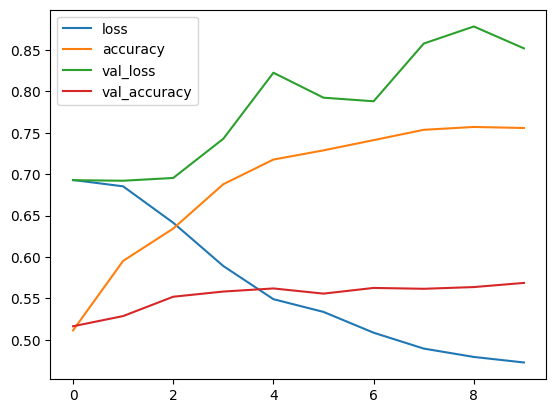

In [ ]:
pd.DataFrame(model_1_history.history).plot()

In [ ]:
model_1.evaluate(test_dataset)

5/5 [==============================] - 1s 148ms/step - loss: 0.8518 - accuracy: 0.5688


[0.8517647385597229, 0.5687500238418579]

In [ ]:
model_1_load = tf.keras.models.load_model(project_path/"model_experiment/model_1_bidirectional/")
model_1_load.evaluate(test_dataset)

5/5 [==============================] - 2s 144ms/step - loss: 0.8518 - accuracy: 0.5688


[0.8517647385597229, 0.5687500238418579]

# Model 1.1 - Behavior Classifier with Multimodal Dataset

**Note: For further improvment experimentation**

## dataset

In [ ]:
multimodal_df = full_dataset[["title", "abstract", "content", "additionalSalaryText", "location", "kind"]]
multimodal_df["full_text"] = multimodal_df["title"] + multimodal_df["abstract"] + multimodal_df["content"]
multimodal_df

<ipython-input-46-9db9333102eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multimodal_df["full_text"] = multimodal_df["title"] + multimodal_df["abstract"] + multimodal_df["content"]


,title,abstract,content,additionalSalaryText,location,kind,full_text
id,,,,,,,
38820886,Pharmacist - Part Time - Melton,Expand your career with a leading pharmacy ret...,A career with endless opportunities is clo...,NaN,Auckland,V,Pharmacist - Part Time - MeltonExpand your car...
38901970,Assistant Director - EL1,"Experienced EL 1 Assistant Director, Strategy ...",face2face reference number: 10600 3 M...,NaN,Melbourne,V,Assistant Director - EL1Experienced EL 1 Assis...
38919645,Property Manager - Luxury Portfolio,Higher Solution Specialists are currently seek...,Higher Solution Specialists is&nbsp;a privat...,NaN,Adelaide,V,Property Manager - Luxury PortfolioHigher Solu...
38928402,Looking for MC Drivers,MC Driver - there's more to them than meets th...,Are you ready to transform and roll out? W...,$68k - $76K p.a. + choice of 15.4% super,Mildura & Murray,V,Looking for MC DriversMC Driver - there's more...
38847632,Executive Officer (ALTG & TACT) - Lung Foundat...,"Pivotal research program position, responsible...",About the Opportunity Lung Foundation Au...,NaN,Sydney,V,Executive Officer (ALTG & TACT) - Lung Foundat...
...,...,...,...,...,...,...,...
38863789,Claims Consultant - Sutherland Location,SME Claims Portfolio Management - Great Career...,Enjoy working in a vibrant and supportive te...,NaN,Mackay & Coalfields,V,Claims Consultant - Sutherland LocationSME Cla...
38977257,ESL Teachers: International Public Speaking St...,Hiring teachers in Sydney & Melbourne. Fun cas...,ABOUT GATEWAY LEARNING&nbsp;&nbsp; Gatew...,NaN,Perth,V,ESL Teachers: International Public Speaking St...
38943585,Travel Experts - Warringah,Want to combine your passion for travel with y...,Want to combine your passion for travel and ...,NaN,Sydney,V,Travel Experts - WarringahWant to combine your...


In [ ]:
BALANCE_SLICE = 12000
text_V = multimodal_df[multimodal_df["kind"]=="V"].iloc[:BALANCE_SLICE]
text_A = multimodal_df[multimodal_df["kind"]=="A"].iloc[:BALANCE_SLICE]

multimodal_df = pd.concat([text_V, text_A])

In [ ]:
X = multimodal_df[["full_text", "location"]]
y = multimodal_df[["kind"]]

X.shape

(24000, 2)

**Insight**

- `additionalSalaryText` has too much `NaN` hence column is dropped for training.

In [ ]:
ohe =  OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,
                                                    test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19200, 2), (4800, 2), (19200, 2), (4800, 2))

## ohe

In [ ]:
# train
text_train_data = X_train["full_text"].to_numpy()
# salary_train_data = X_train["additionalSalaryText"].to_numpy()
location_train_data = X_train["location"].to_numpy().reshape(-1, 1)

ohe_location_train = OneHotEncoder(sparse_output=False)
location_train_data_ohe = ohe_location_train.fit_transform(location_train_data)

# salary_train_data_ohe = tf.one_hot(salary_train_data, depth=161)
# location_train_data_ohe = tf.one_hot(location_train_data, depth=50)

In [ ]:
ohe_location_train.categories_

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
ohe_location_train

In [ ]:
# test
text_test_data = X_test["full_text"].to_numpy()
# salary_test_data = X_test["additionalSalaryText"].to_numpy()
location_test_data = X_test["location"].to_numpy().reshape(-1, 1)

ohe_location_test = OneHotEncoder(sparse_output=False)
location_test_data_ohe = ohe_location_test.fit_transform(location_test_data)

# salary_test_data_ohe = tf.one_hot(salary_test_data, depth=161)
# location_test_data_ohe = tf.one_hot(location_test_data, depth=50)

In [ ]:
location_train_data_ohe.shape

(19200, 50)

## data pipeline

In [ ]:
print(text_train_data.shape),
print(tf.squeeze(location_train_data_ohe).shape)

(19200,)
(19200, 50)


In [ ]:
text_test_data.shape, location_test_data_ohe.shape

((4800,), (4800, 50))

In [ ]:
# train


feature_train_dataset = tf.data.Dataset.from_tensor_slices((
                            text_train_data,
                            tf.squeeze(location_train_data_ohe)
))
kind_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

train_dataset = tf.data.Dataset.zip((feature_train_dataset,
                             kind_dataset_train))

train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

# test
feature_test_dataset = tf.data.Dataset.from_tensor_slices((
                            text_test_data,
                            tf.squeeze(location_test_data_ohe)
))
kind_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)


test_dataset = tf.data.Dataset.zip((feature_test_dataset,
                                    kind_dataset_test))

test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>)

In [ ]:
len(full_dataset["additionalSalaryText"].unique())

161

In [ ]:
len(full_dataset["location"].unique())

50

## layers

In [ ]:
model_1_1_embedding = create_embedding()
text_vectorizer.adapt(text_train_data)

In [ ]:
# token
token_inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(token_inputs)
x = model_1_1_embedding(x)
x = layers.Bidirectional(layers.LSTM(units=64,
                                     return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
token_outputs = layers.Dense(units=32, activation="relu")(x) # binary
token_model = tf.keras.Model(
    token_inputs, token_outputs, name="token_model"
)

# salary (removed due to high amount of NAN)
# salary_class_n = 161
# salary_inputs = layers.Input(shape=(salary_class_n), dtype=tf.float32)
# salary_outputs = layers.Dense(units=32, activation="relu")(salary_inputs)
# salary_model = tf.keras.Model(salary_inputs, salary_outputs, name="salary_model")

# location
location_class_n = 50
location_inputs = layers.Input(shape=(location_class_n), dtype=tf.float32)
location_outputs = layers.Dense(units=32, activation="relu")(location_inputs)
location_model = tf.keras.Model(location_inputs, location_outputs, name="location_model")


multimodal_layer = layers.Concatenate(
    axis=1, name="tribrid_embedding",
    )([
        token_model.output,
        # salary_model.output,
        location_model.output,
    ])

# output
output_layer = layers.Dense(2, activation="sigmoid")(multimodal_layer)

model_1_1 = tf.keras.Model(
            inputs=[token_inputs,
                    # salary_inputs,
                    location_inputs],
            outputs=output_layer,
            name="model_1_1_multimodal"
)

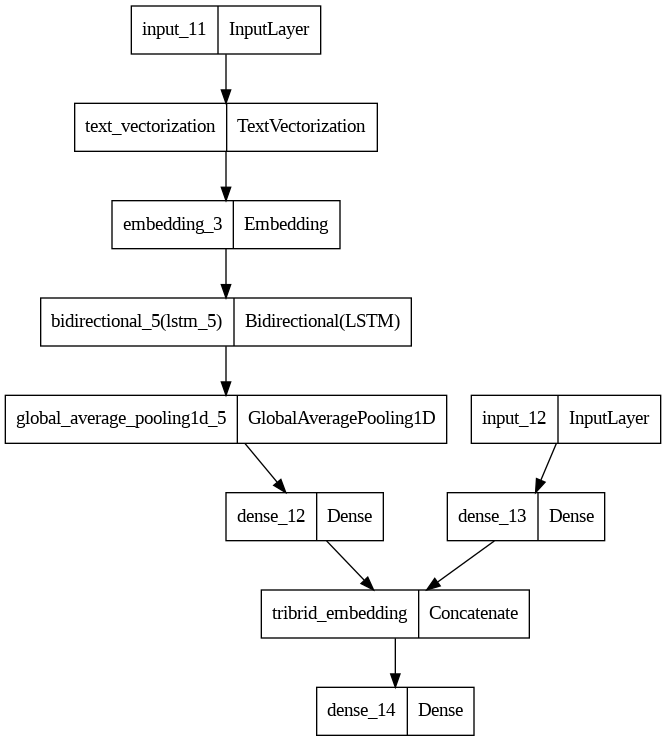

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1_1)

## compile

In [ ]:
model_1_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

In [ ]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>)

## fit

In [ ]:
!nvidia-smi

Sun Jan 14 04:27:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              28W /  70W |   1169MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
model_1_1_history = model_1_1.fit(
    train_dataset,
    validation_data = (test_dataset),
    epochs=10,
    verbose=0,
    callbacks=[create_model_checkpoints(model_1_1.name),
               TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

<Axes: >

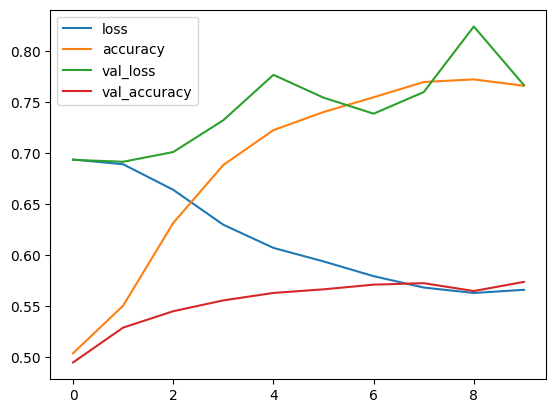

In [ ]:
pd.DataFrame(model_1_1_history.history).plot()

In [ ]:
model_1_1.evaluate(test_dataset)

5/5 [==============================] - 0s 68ms/step - loss: 0.7667 - accuracy: 0.5740


[0.7667246460914612, 0.5739583373069763]

In [ ]:
model_1_1_load = tf.keras.models.load_model(project_path/"model_experiment/model_1_1_multimodal/")
model_1_1_load.evaluate(test_dataset)

5/5 [==============================] - 2s 90ms/step - loss: 0.7667 - accuracy: 0.5740


[0.7667246460914612, 0.5739583373069763]

## 20 epoch

In [ ]:
del model_1_1

0epoch [00:00, ?epoch/s]

<Axes: >

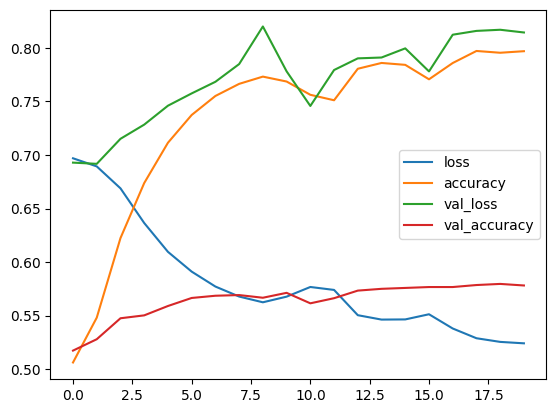

In [ ]:
EPOCHS = 20

model_1_2_history = model_1_1.fit(
    train_dataset,
    validation_data = (test_dataset),
    epochs=EPOCHS,
    verbose=0,
    callbacks=[create_model_checkpoints("model_1_1_multimodel_epoch_20"),
               TqdmCallback(verbose=0)]
)
pd.DataFrame(model_1_2_history.history).plot()

In [ ]:
model_1_1.evaluate(test_dataset)

5/5 [==============================] - 1s 109ms/step - loss: 0.8145 - accuracy: 0.5781


[0.8144588470458984, 0.578125]

## user-data pipeline

In [ ]:
tf.squeeze(tf.squeeze(ohe_location_train.transform([["ACT"]]))).shape

TensorShape([50])

In [ ]:
def input_pipeline(job_description:list, location:list):

    data = {"text":job_description, "location":location}
    input_df = pd.DataFrame(data)

    text = input_df["text"].to_numpy()
    location = input_df["location"].to_numpy().reshape(-1, 1)
    # print(text)
    # print(text.shape)
    # ohe_location = OneHotEncoder(sparse_output=False)
    try:
        location_data_ohe = ohe_location_train.transform(location)

        # print(location_data_ohe)
        # print(location_data_ohe.shape)
        #print(tf.squeeze(location_data_ohe).shape)
        # location_test_data_ohe = tf.one_hot(location_data_ohe, depth=50)
        input_slice = tf.data.Dataset.from_tensor_slices((
                                                text,
                                                location_data_ohe
        ))


        # filler
        output_filler = tf.tile(tf.expand_dims(tf.zeros(2), axis=1), [1,2])
        output_filler = tf.data.Dataset.from_tensor_slices(output_filler)

        input_zip = tf.data.Dataset.zip((input_slice,
                                        output_filler)
        )

        user_input = input_zip.batch(1024).prefetch(tf.data.AUTOTUNE)

        return user_input
    except:
        print(f"ERROR: Location is {location} not found")

user_input = input_pipeline(["Heyyy"], ["Melbourne"])
user_input
"""
((19200,), TensorShape([19200, 50]))
"""

'\n((19200,), TensorShape([19200, 50]))\n'

In [ ]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 50), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>)

In [ ]:
model_1_1_loads =tf.keras.models.load_model(project_path/"model_experiment/model_1_1_multimodal/")

In [ ]:
user_input = input_pipeline(
    ["Not a good job"],
    ["Perth"])
model_1_1_preds = model_1_1_loads.predict(user_input)
model_1_1_argmax = tf.math.argmax(tf.squeeze(model_1_1_preds).numpy())
model_1_1_pred_arg = ohe.categories_[0][model_1_1_argmax]
print(f"Prediction behavior: {model_1_1_pred_arg}")

1/1 [==============================] - 0s 32ms/step
Prediction behavior: V


In [ ]:
model_1_1

array([[0.7059273 , 0.28326744]], dtype=float32)

# Model 2: JobRecommender

## Model 2
- Build a model to classify the `classification` (job classification) by using full text (`title, abstrac and content`).

### prepare dataset

In [ ]:
SLICE = 1000

jobrec_dataset = full_dataset[["title", "abstract", "content", "classification"]]
jobrec_dataset["full_text"] = jobrec_dataset.apply(lambda x:combine_all_text(x), axis=1)

jobrec_dataset = jobrec_dataset.sample(frac=1)

X = jobrec_dataset["full_text"].iloc[:SLICE].to_numpy()
y = jobrec_dataset["classification"][:SLICE].to_numpy().reshape(-1, 1)

<ipython-input-61-905dceff5ef8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobrec_dataset["full_text"] = jobrec_dataset.apply(lambda x:combine_all_text(x), axis=1)


In [ ]:
len(jobrec_dataset["classification"].unique())

29

In [ ]:
ohe =  OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y)
# y_ohe = tf.one_hot(y_ohe,)
print(y_ohe)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
ohe.categories_

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,
                                                    test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800,), (200,), (800, 29), (200, 29))

### pipeline

In [ ]:
text_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
kind_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)

train_dataset = tf.data.Dataset.zip((text_train_dataset, kind_train_dataset))
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)


text_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
kind_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

test_dataset = tf.data.Dataset.zip((text_test_dataset, kind_test_dataset))
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 29), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 29), dtype=tf.float64, name=None))>)

In [ ]:
text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    output_sequence_length=15,
                                    )

In [ ]:
text_vectorizer.adapt(text_train_dataset)

### model

In [ ]:
model_2_embedding = create_embedding()

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_2_embedding(x)

# layers
x = layers.Bidirectional(layers.LSTM(units=64,
                                     return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(29, activation="softmax")(x) # binary

model_2 = tf.keras.Model(inputs, outputs, name="model_2_bidirectional_jobrec_tagger")
model_2.summary()

Model: "model_2_bidirectional_jobrec_tagger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 15, 128)           98816     
 onal)                                                           
                                                                 
 global_average_pooling1d_3  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                               

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

### fit

In [ ]:
model_2_history = model_2.fit(
    train_dataset,
    epochs=10,
    validation_data=(test_dataset),
    verbose=0,
    callbacks=[create_model_checkpoints(model_2.name),
               TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

<Axes: >

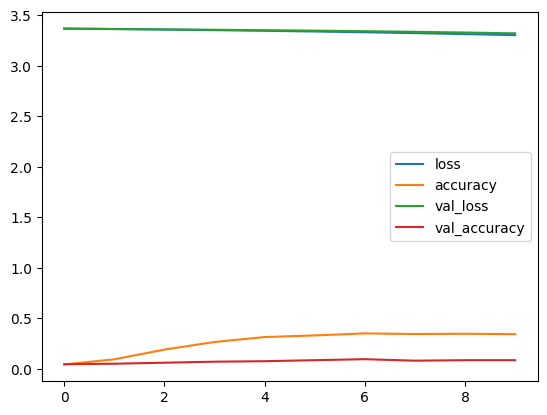

In [ ]:
pd.DataFrame(model_2_history.history).plot()

In [ ]:
model_2.evaluate(test_dataset)

1/1 [==============================] - 0s 72ms/step - loss: 3.3186 - accuracy: 0.0850


[3.3186306953430176, 0.08500000089406967]